# Large Scale Objects Phase Measuring Deflectometry 

<font size="4">This Jupyter Notebook provides the whole process of phase measuring deflectometry process. The whole process can be devided into the following sections:
1. Glue aruco markers on the object and mirror used on calibration.
2. Image acquisition. This part is done via another independent program.
3. Intrinsic calibration.
4. Geometric calibration
5. Surface normal calculation.

In the following sections, details within these process will be introduced. Following the guideline, you should be able to perform a surface reconstruction smoothly</font>

## I. Glue Aruco Markers

<font size="4">Before you take any picture, you need to print and glue aruco markers on the mirror (used for calibration) and object you would like to reconstruct. Placing those markers in right order on right positions are crutial to high-precision reconstruction. Please read the guideline carefully and glue markers following guideline!
    
In our precedure, we assume the mirror and object are rectangular. So we recommend using rectangular mirror. If your object is not rectangular (e.g. a round-shape object), you can place the object on a rectangular board and place markers on the board.


The markers are in file *6x6_40mm.pdf*. Make sure that this file is printed without any scaling. Each markers should be 50*50mm (with edges). Then place the markers as is shown in the following figure</font>

![reproejct_markers.png](./reproejct_markers.png)

<font size="4">Marker #0 is on the upperleft side of the corner, then marker #1 on middle point of the left side, and so on. The markers are glued in the anti-clockwise order.<font size="4">

## II. Building Environment

<font size="4">Now we have collected the photos we need, we can perform the calibration and normal reconstruction. In order to do this, you need to be equipped with the following installed:
1. Numpy
2. OpenCV-contrib (v4.3.0 or higher)
3. Checkerboard
4. Tqdm
5. Scipy
6. Matplotlib

We recommend you to first create an anaconda environment, then install these packages. To install these packages, you can use pip or conda commands.


In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import cv2
from cv2 import aruco
import matplotlib
import matplotlib.pyplot as plt
from Calibrations import charucoMarkerCalib as cm
from Calibrations import geocalib as gc
from Calibrations import geocalibII as gc2
from Reconstructions import PMD as pmd
from Reconstructions import normal2RGB

In [ ]:
from Cameras import Webcam
from Cameras import MachineVision
from Projections import MainScreen
from Calibrations import RadiometricCalibration
from CalibrationsSessions import RadiometricCalibSession, RadiometricCalibDisplaySession

## III. Taking Photos

<font size="4">Then you need to take a seires of photos in order to perform the PMD procedure. This can be divided into the two step.

First, place the mirror in front of the camera. Take a photo of mirror with checkerboard pattern on display. Please make sure that all checkerboard squares are on the mirror and not occluded by the marker, like the figure above shows.

Second, keep the position of camera and screen still (NOTE: This is IMPORTANT! otherwise we need to redo step 1). Place the object in front of the camera, then run the image acquisition program to take photo of objects when sinusoidal patterns are projected.

After then, we can collect 9 photos. One photo of the mirror, and eight photos of the object.</font> 

## set up camera
choose your camera and set up

laptop webcam

In [ ]:
# internal Webcam
cam = Webcam.Internal()
# set resolution
cam.setResolutionJupyter((640, 480))
# capture image
frame = cam.getImage(name='anything', saveImage=False, saveNumpy=False)
# view camera stream
cam.viewCameraStreamJupyter()
# close camera
cam.quit_and_close()

USB webcam

In [ ]:
# external Webcam
cam = Webcam.External()
# to do

Raspberry camera

In [ ]:
# Raspberry camera
cam = Raspberry.RaspberryCam()
# to do

Basler camera

In [ ]:
# Basler
cam = MachineVision.Basler()
# to do

Flir camera

In [ ]:
# Flir initial
cam = MachineVision.Flir()
# set exposure time 
cam.setExposure(30000)
# set gain
cam.setGain(0)

In [ ]:
# Flir camera caputer images
# capture one image
cam.captureImage(fname = 'test1') # This image is stored as "CapturedImages/test1.png"
cam.getImage() # This image is stored as "CapturedImages/test.png"
# capture images for calibration
# calibrationName can be 'Intrinsic', 'Geometric' etc.
# images are stored in CalibrationImages/calibrationName file
cam.getImage(calibration = True, calibrationName = 'Intrinsic') 
cam.getImage(calibration = True, calibrationName = 'Geometric')

# capture sequence images with sin pattern in two directions
# the projector show patterns and camera capture images of the object
cam.captureSeqImages() # images are stored in "CapturedImages/sequenceImages" file

## set up screen
set up screen if you want.

In [ ]:
projection = MainScreen.Screen()

## IV Intrinsic Calibration

<font size="4">The next step is intrinsic calibration. In our setup, we use the built-in function of OpenCV. Detailed documents can be seen here:
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html

Basically, you need a calibration checkerboard with aruco markers. Then take several images under different camera poses. You can find and print the checkerboard pdf file.

There are some tips of taking image series:
1. Make sure the checkerboard is "large enough in camera's view. The checkerboard should take at least 1/4 of camera view. The recommended portion is 1/3.
2. Place the printed checkerboard on a hard plane, e.g. a hard paper board or a gater board.
3. Try more camera poses, like rotation and translation.
4. The recommend number of images are between 10-20. In our setup, we use 16.

After acquiring these image, we can run intrinsic calibration program. Before you do it, you need to know the number of squres (on horizontal and vertical direction), size of black ckecker and size of marker (in meter). 

This program performs two functions:
1. Calculate camera intrinsic matrix and distortion coefficient.
2. Use the calculated camera parameters to undistort images you took in stage II (mirror and object photos).

So when running this program, you also need to know the input image folder (the checkerboard images), and the output imges folder (used to store undistorted mirror/object pictures).

In [2]:
# intrinsic calibration
sqWidth = 11 # number of squares width
sqHeight = 8 # number of squares height
checkerSquareSize = 0.021 # size of the checker square in (meter)
markeSquareSize = 0.016 # size of the marker square in (meter)
imgFolder = os.path.join(os.path.join(os.getcwd(), 'CalibrationImages'), 'Intrinsic')
imgDistortFolder = os.path.join(os.path.join(os.getcwd(), 'CapturedImages'), 'sequenceImages')
# imgFolder='C:\\Users\\18722\\Downloads\\Deflectometry Code and Data\\Deflectometry Code and Data\\calibration\\calib0422'
# imgFolder = 'C:\\Users\\18722\\Downloads\\structured_light_framework-master\\structured_light_framework-master\\CalibrationImages\\Intrinsic'
# imgDistortFolder='C:\\Users\\18722\\Downloads\\structured_light_framework-master\\structured_light_framework-master\\CapturedImages\\sequenceImages'
ret, cameraMatrix, disCoeffs = cm.calibration(imgFolder, imgDistortFolder, 'calibration.npz', sqWidth, sqHeight, checkerSquareSize, markeSquareSize)

NumImg: 21
(1200, 1920, 3)
Reprojection Error: 0.8378265034540633
Camera Intrinsic Matrix: [[2.08433383e+03 0.00000000e+00 9.42068208e+02]
 [0.00000000e+00 2.09956595e+03 6.01826671e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coeffs: [[ 3.25711639e+00  1.55101487e+01 -1.00452433e-03  1.79794214e-03
   1.49753196e+01  3.63471007e+00  1.66600358e+01  2.32800917e+01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
image undistorted C:\Users\18722\Downloads\structured_light_framework-master\structured_light_framework-master\CapturedImages\sequenceImages\0.png
image undistorted C:\Users\18722\Downloads\structured_light_framework-master\structured_light_framework-master\CapturedImages\sequenceImages\1.png
image undistorted C:\Users\18722\Downloads\structured_light_framework-master\structured_light_framework-master\CapturedImages\sequenceImages\2.png
image undistorted C:\Users\18722\Downloads\structured_light_framework-

## V. Geometric Calibration

<font size="4">After intrinsic calibration, you need to do geometric calibration. The purpose of geometric calibration is to calculate pose, i.e. rotation and translation between object, camera and display. 

When doing geometric calibration, you need the image of the mirror, with reflected checkerboard from display (both original and undistorted). Also, you need to know the dimension of the mirror and the size of checkersquare on the screen. After the geometric calibration program, you can see the visualized mirror, camera and display in a world coordinate system. If everything works on well, you should see them placed at similar positions as they are placed in the real-world.

In [3]:
# undistort images, which will be used in geometric calibation, with result from intrinsic calibration
imgFolder = os.path.join(os.path.join(os.getcwd(), 'CalibrationImages'), 'Intrinsic')
imgDistortFolder = os.path.join(os.path.join(os.getcwd(), 'CalibrationImages'), 'Geometric')
ret, cameraMatrix, disCoeffs = cm.calibration(imgFolder, imgDistortFolder, 'calibration.npz', sqWidth, sqHeight, checkerSquareSize, markeSquareSize)
# undistorted image is saved in undistort file as 0.png

NumImg: 21
(1200, 1920, 3)
Reprojection Error: 0.8378265034540633
Camera Intrinsic Matrix: [[2.08433383e+03 0.00000000e+00 9.42068208e+02]
 [0.00000000e+00 2.09956595e+03 6.01826671e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coeffs: [[ 3.25711639e+00  1.55101487e+01 -1.00452433e-03  1.79794214e-03
   1.49753196e+01  3.63471007e+00  1.66600358e+01  2.32800917e+01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
image undistorted C:\Users\18722\Downloads\structured_light_framework-master\structured_light_framework-master\CalibrationImages\Geometric\test.png
Intrinsic calibration complete!


reProjAruco


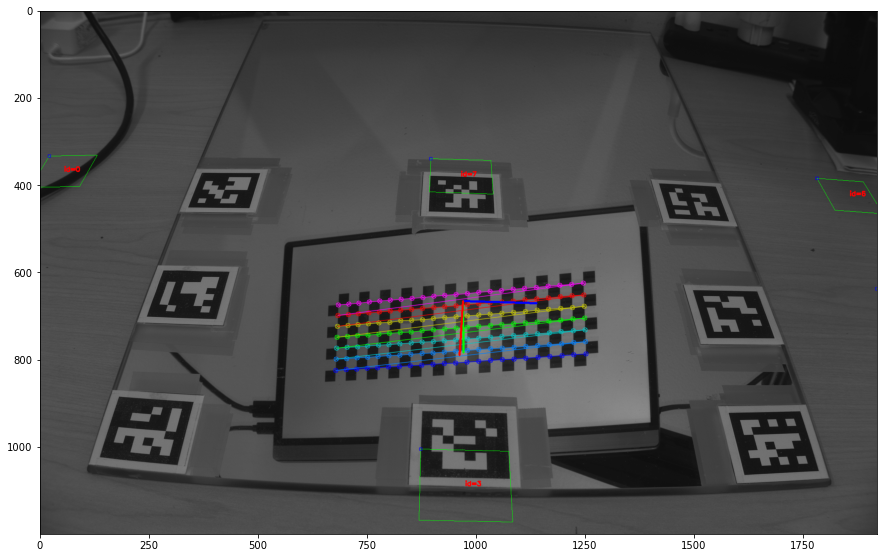

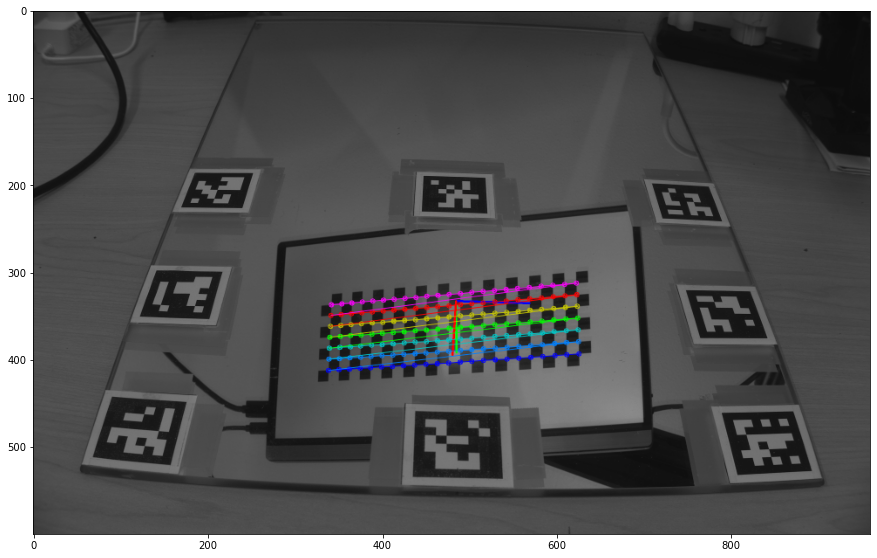

[[0.00456741]
 [0.05127237]
 [0.84480896]]
rC2S: [[ 0.93776589  0.34035361  0.06895322]
 [-0.02891524 -0.12134126  0.9921896 ]
 [-0.34606218  0.93243537  0.10394829]]
tC2S: [ 0.05775967 -0.56971599  0.26986691]


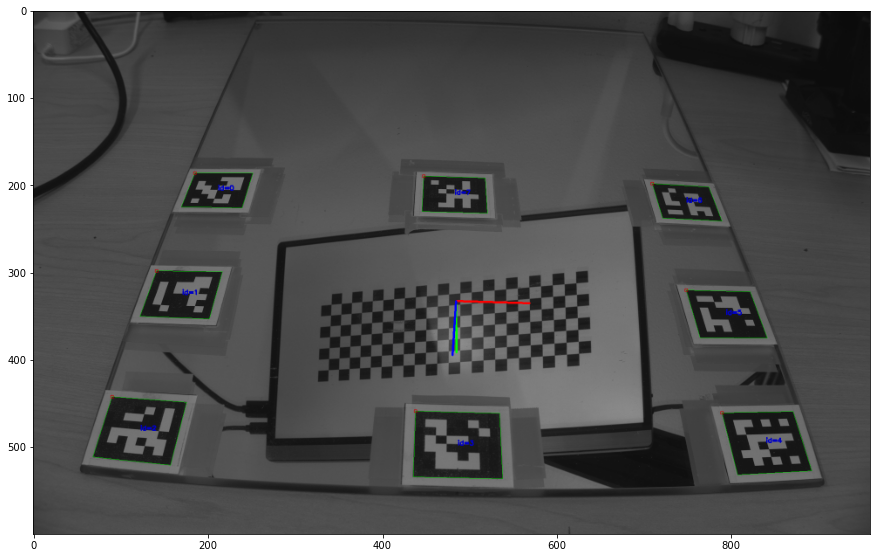

cam z axis in world coor is  [ 0.02186937 -0.78261962  0.62211596]
cam zero point in world coor is  [-0.017542    0.37267625 -0.31508491]
display z axis in world coor is  [-0.31652077  0.49941291  0.80647464]
display zero in world coor is  [ 0.00698468 -0.25657507 -0.25041762]


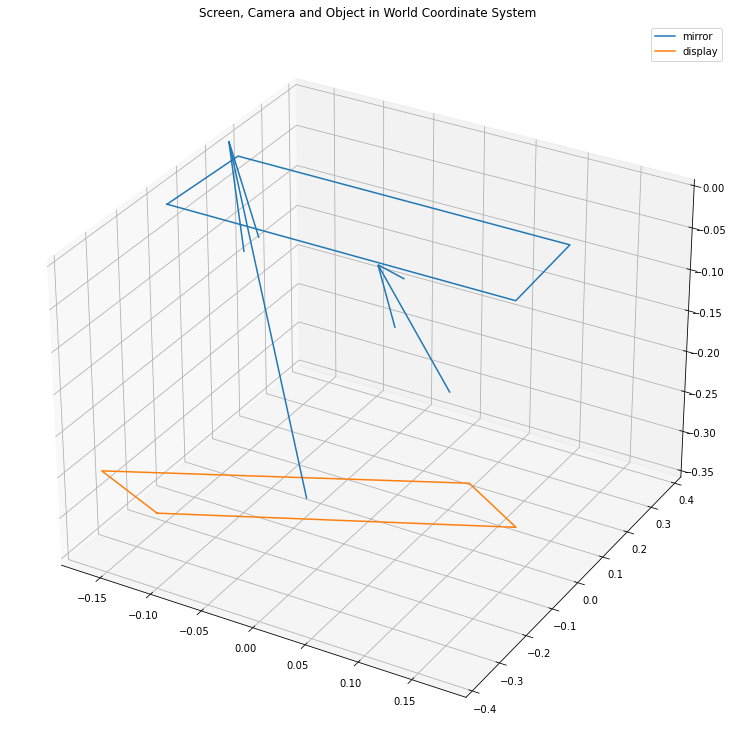

In [9]:
# geometric calibration part 1
# half length and width of mirror, -0.005 represents that the outer corner of marker is 5mm blank edge, which needs to be distracted.
half_length = 0.342 / 2
half_height = 0.243 / 2
# display scale factor, which is the ratio of single checker square length between metric and pixel unit.
# for example, if the length of a checker square on display in 65mm, and it takes 60 pixel in screen, so the ratio is 0.065/60.
displayScaleFactor = 0.011 / 60 #0.0011

# location of raw distorted image
geoCalibImgFile = os.path.join(os.path.join(os.path.join(os.getcwd(), 'CalibrationImages'), 'Geometric'), 'test.png')
# location of undistorted image
geoCalibImgUndistortFile = os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), 'CalibrationImages'), 'Geometric'), 'undistort'),'0.png')
displayintersect, camdisintersect, rc2s, tc2s = gc.geoCalib(geoCalibImgFile, geoCalibImgUndistortFile, half_length, half_height, cameraMatrix, disCoeffs, ret, displayScaleFactor)
# result images are saved in geoCalibResults file

<font size="4">Then, you can run a verification program to check the precision of geometric calibration. In this program, we will use the calculated rotation and translation between mirror, camera and screen to "project" checker pattern on the screen back to image coordinate system. Then, you can compare the reprojected checker pattern and the actual checker pattern in the image. For a high-presicion geometric calibration, two patterns should be coincide (or nearly coincide) in the image. To help you compare difference between two patterns, the program shows the picture with two patterns overlaid.</font> 

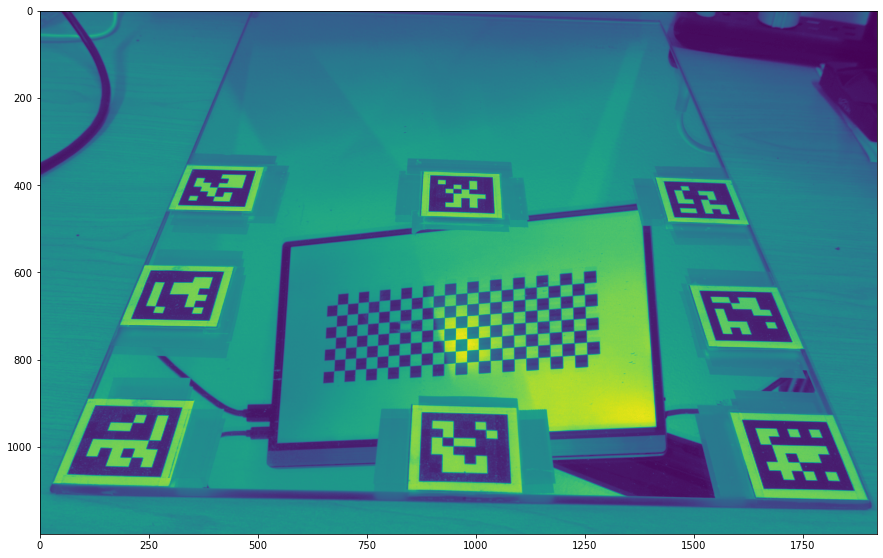

(1200, 1920)


In [5]:
# geometric calibration validation
gc2.geoCalibII(geoCalibImgUndistortFile, displayintersect, displayScaleFactor)

## VI. Radiometric Calibration

setp 1: Camera calibration

setp 2: Display calibration

step 3: calculate and undistort images

In [ ]:
# camera calibration

# Set up the calibration object
radio_calib = RadiometricCalibration.RadiometricCalibration(cam.getResolution())

# Set up the calibration session by passing on the camera and the calibration object
# To set your own exposures please pass them to the RadiometricCalibSession when creating
radio_calib_session = RadiometricCalibSession.RadiometricCalibSession(cam, radio_calib)

# Capture images with different exposures
radio_calib_session.capture()

# calculation curve function
g, g_n = radio_calib_session.calibrate_HDR(smoothness=500)

# if data is stored
radio_calib.load_calibration_data()
radio_calib.plotCurve('Grayscale')

In [ ]:
# display calibration
# initial 
radio_calib_display = RadiometricCalibDisplaySession.RadiometricCalibDisplaySession(cam, radio_calib)

# capture images of display of different pixels
radio_calib_display.captureImages()

# calculate reflectivity 
radio_calib_display.calculateReflectivity()
# result images: Display to Relative Radiance Curve, Display Value to Average Pixel Value Curve

In [ ]:
# just to undistort images 
radio_calib = RadiometricCalibration.RadiometricCalibration(cam.getResolution())
radio_calib_display = RadiometricCalibDisplaySession.RadiometricCalibDisplaySession(cam, radio_calib)
radio_calib_display.radiometricCalibUndistortImages()
# undistorted images are saved in 'CapturedImagessequenceImages/undistortRadioCalib'

## VII. Normal Calculation

<font size="4">Finally! Now after verifying the geometric calibration result, you can now reconstruct surface normals of object. In this stage, we can you the rotation and translation between camera and display from the previous stage (Now you understand why you need to make camera and display still when switching from mirror to object). But since the position of object may be different from position of the mirror, wo actually in this stage, you need to perform geometric calibration again.

In order to do it, you need to know the following parameters:
1. The folder of **undistorted** photos of object (sinusoid pattern reprojected).
2. The path of an **original** image of object (anyone within the object image series would be fine).
3. The folder you would like to store results, aka reconstructed normal map of object.
4. The dimensions of object.</font>

C:\Users\18722\Downloads\structured_light_framework-master\structured_light_framework-master\CapturedImages\sequenceImages\undistortRadioCalib\*.png
(4, 1200, 1920)


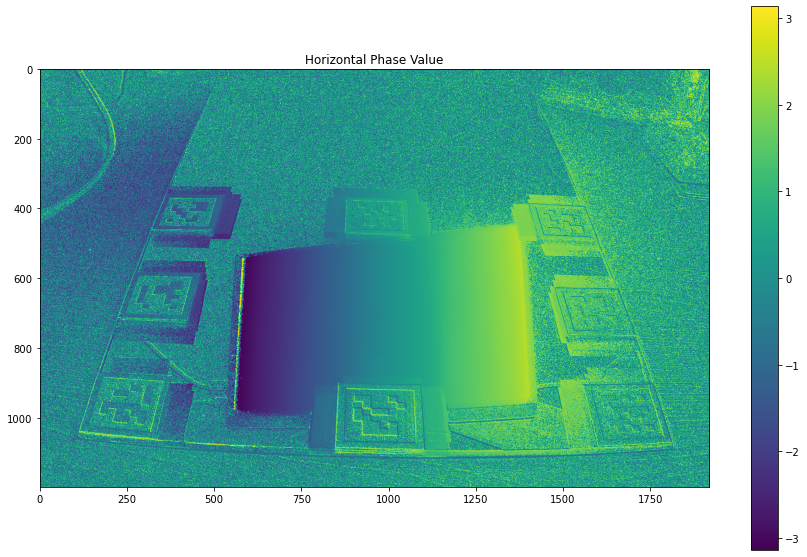

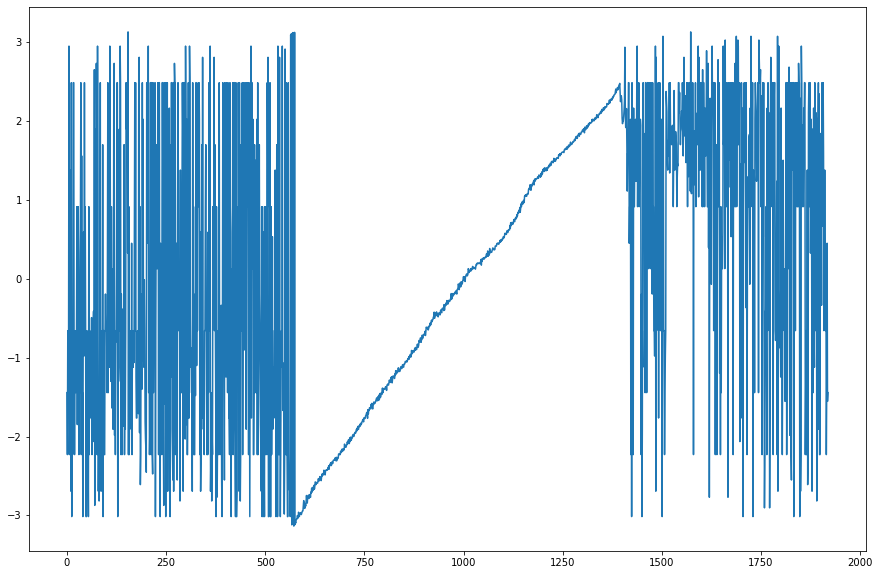

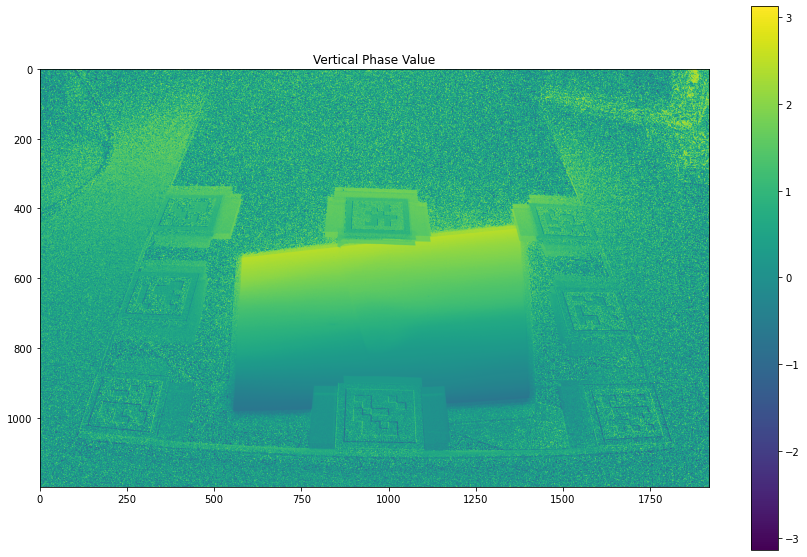

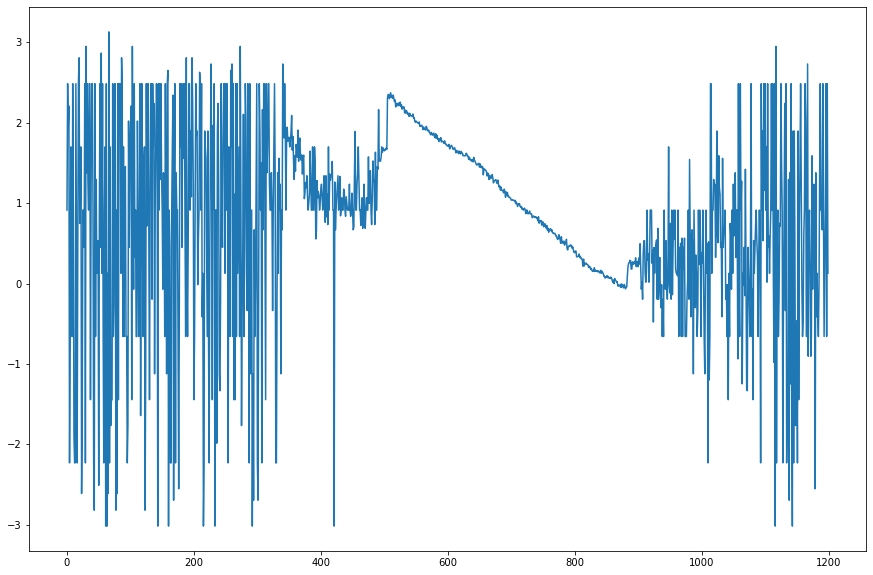

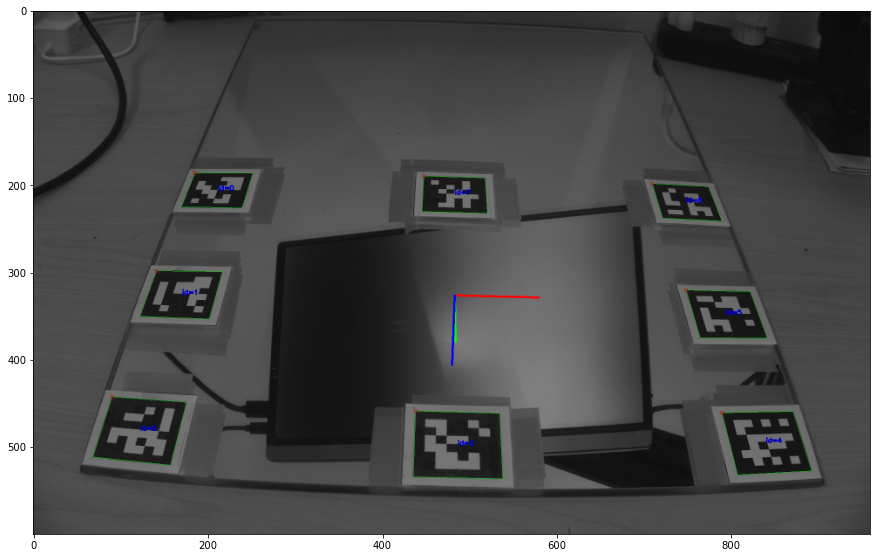

normal map generated.
0.294799506939051
0.26939989754499205


In [6]:
# final PMD surface reconstruction part. This will generate normal file.
sinusoidImgPath = os.path.join(os.path.join(os.path.join(os.getcwd(), 'CapturedImages'), 'sequenceImages'), 'undistortRadioCalib')
addImgPath = os.path.join(os.path.join(os.path.join(os.getcwd(), 'CapturedImages'), 'sequenceImages'), '0.png')
normalFolder = os.path.join(os.path.join(os.path.join(os.getcwd(), 'CapturedImages'), 'sequenceImages'), 'results')
# half length and half height of reconstructed object. Also need to substract 0.005
half_length_obj = 0.1524 - 0.005
half_height_obj = 0.1397 - 0.005
normalImage, normal_mat_origin, normalmap_world = pmd.PhaseMeasuringDeflectometry(rawImgPath=sinusoidImgPath, addImgPath= addImgPath, normalPath= normalFolder, metric_factor= displayScaleFactor, cameraMatrix= cameraMatrix, disCoeffs= disCoeffs, ret= ret, rc2s= rc2s, tc2s= tc2s, half_length= half_length_obj, half_height= half_height_obj)
# result images are saved in 'CapturedImagessequenceImages/results'

<font size= "4">Now you can visualize the normal map you calculated!
There're three different normal maps generated from previous step. They are:
1. Normal map encoded into an RGB image (x, y, z components of the normal vector represents R, G and B value of each pixel).
2. Normal map under camera perspective
3. Normal map under world perspective </font>

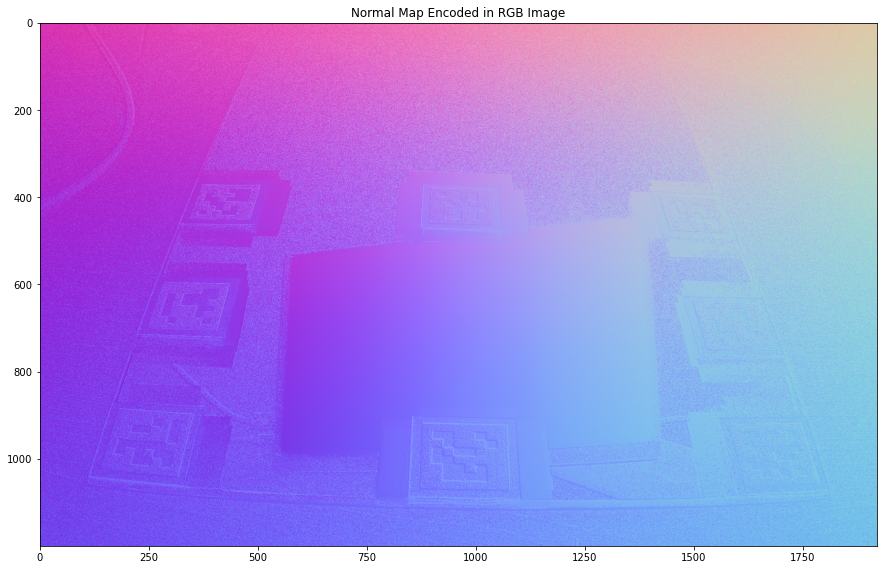

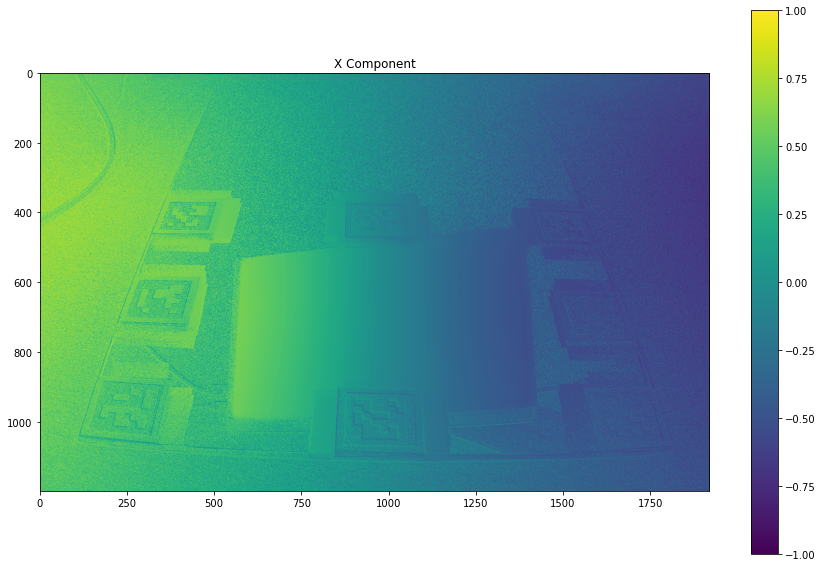

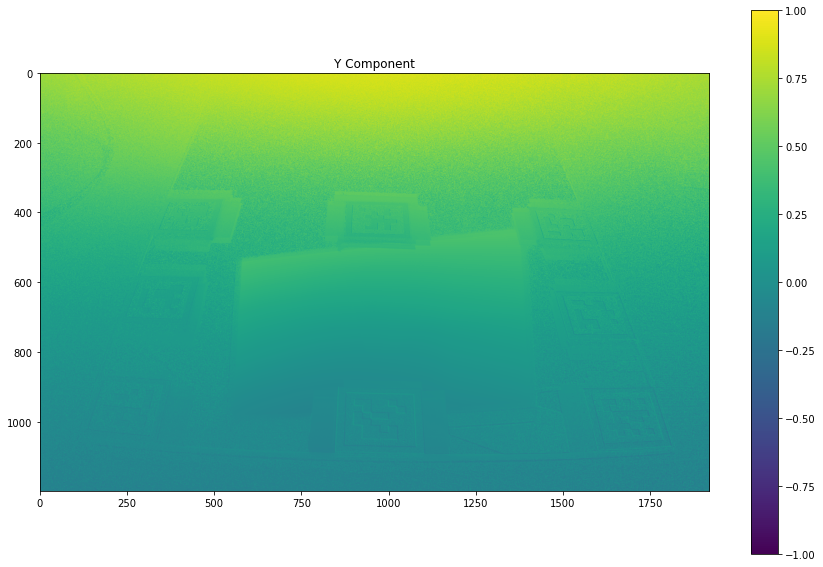

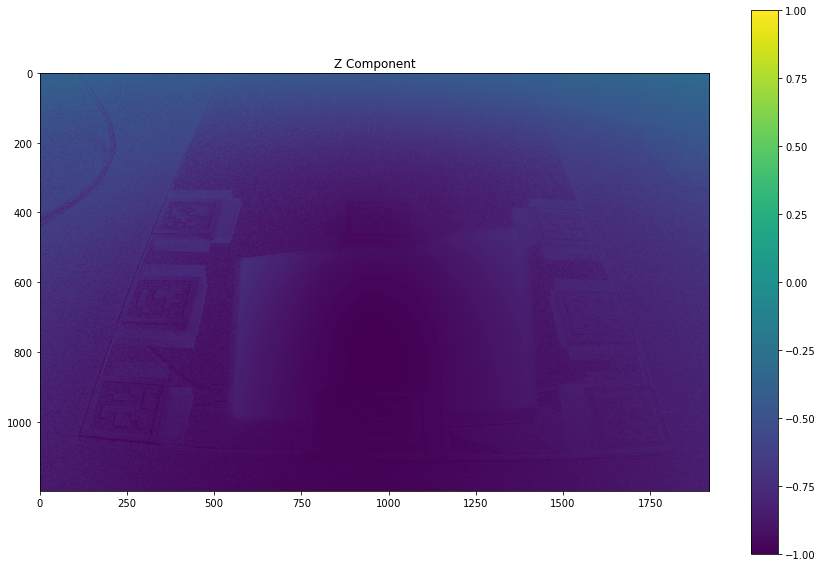

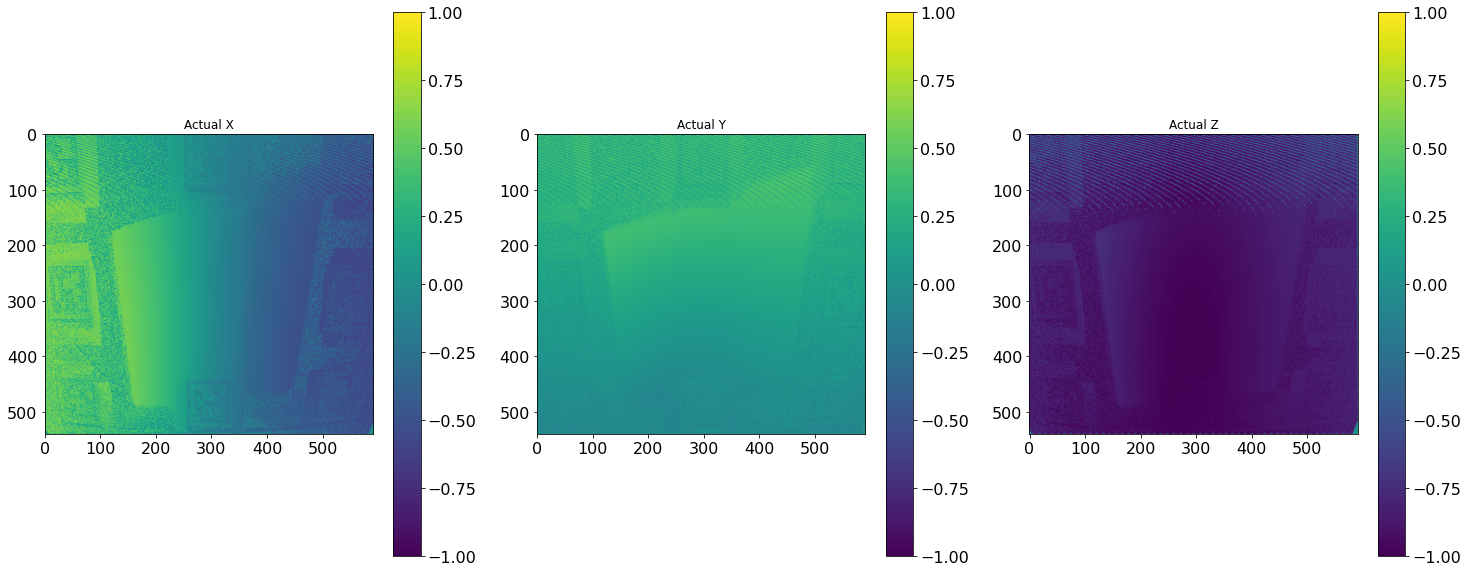

In [7]:
normal2RGB.normal2RGB(normalImage, normal_mat_origin, normalmap_world)
# result images are saved in 'CapturedImagessequenceImages/results'